In [94]:
%pip install tensorflow

In [22]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
from tensorflow import keras

class SnakeEnv:
  def __init__(self, grid_size=8, max_steps=200):
    self.grid_size = grid_size
    self.max_steps = max_steps
    self.reset()
  def reset(self):
    self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)
    self.grid[0, 0] = 1
    self.steps = 0
    self.done = False
    self.rewards = 0
    self.snake = deque([(0, 0)])
    self.spawn_fruit()
    return self.get_obs()
  def spawn_fruit(self):
    occupied = set(self.snake)
    empty = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size) if (i, j) not in occupied and self.grid[i, j] < 5]
    if empty:
      fx, fy = random.choice(empty)
      self.grid[fx, fy] = 3
      return True
    else:
      return False
  def get_obs(self):
    return self.grid
  def render(self):

    plt.figure(figsize=(5, 5))
    plt.imshow(self.grid, cmap=mcolors.ListedColormap([
        'white',      # 0 空格
        'black',        # 1 蛇頭
        'green',    # 2 身體
        'yellow',    # 3 果實
    ]), vmin=0, vmax=3)

    # 加格線
    plt.xticks(range(self.grid_size))
    plt.yticks(range(self.grid_size))
    plt.grid(True, which='both', color='gray', linewidth=0.5)
    plt.gca().set_xticks([x - 0.5 for x in range(1, self.grid_size)], minor=True)
    plt.gca().set_yticks([y - 0.5 for y in range(1, self.grid_size)], minor=True)
    plt.gca().tick_params(which='minor', size=0)

    plt.title(f"Step: {self.steps}  |  rewards: {self.rewards} ")
    plt.show()
  def step(self, actions):
    if self.done:
      return self.get_obs(), self.rewards, True, {}
    self.steps += 1
    alive = self.move_snake( actions)
    if not alive  or self.steps >= self.max_steps:
      self.done = True
    return self.get_obs(), self.rewards, self.done, {}
  def move_snake(self, action):
    head = self.snake[-1]
    dir_map = {'up': (-1, 0), 'down': (1, 0),'left': (0, -1), 'right': (0, 1)}
    dx, dy = dir_map[action]
    new_head = (head[0] + dx, head[1] + dy)
    # 判斷撞牆
    if not (0 <= new_head[0] < self.grid_size and 0 <= new_head[1] < self.grid_size):
      return False
    # 撞自己或對方
    all_bodies = set(self.snake)
    if new_head in all_bodies:
      return False
    # 果實處理
    cell = self.grid[new_head]
    ate_own_fruit = (cell == 3 )
    # 移動
    self.grid[self.snake[-1]] = 2
    self.snake.append(new_head)
    self.grid[new_head] =1
    if ate_own_fruit:
      self.rewards += 1
      self.steps=0
      return self.spawn_fruit()
    else:
      self.grid[self.snake[0]] = 0
      self.snake.popleft()
    return True

In [23]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        # Flatten the observation and add batch dimension
        obs_tensor = tf.constant(obs.flatten(), dtype=tf.float32)[tf.newaxis]
        # Predict action probabilities
        action_probas = model(obs_tensor)

        # Debugging: Check action_probas
        # print(f"Action Probas: {action_probas.numpy()}")
        # assert tf.reduce_sum(action_probas) > 0.99 and tf.reduce_sum(action_probas) < 1.01, f"Action probas do not sum to 1: {tf.reduce_sum(action_probas).numpy()}"
        # assert tf.reduce_min(action_probas) >= 0 and tf.reduce_max(action_probas) <= 1, f"Action probas out of bounds: {action_probas.numpy()}"

        # Randomly choose an action based on probabilities
        # Ensure numerical stability by adding a small epsilon before taking log
        log_probas = tf.math.log(action_probas + 1e-8)
        # Debugging: Check log_probas
        # print(f"Log Probas: {log_probas.numpy()}")

        action_index_tensor = tf.random.categorical(log_probas, num_samples=1)[0, 0]
        action_index = int(action_index_tensor.numpy())

        # Map action index to action string
        action_map = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}
        # Add a check to ensure action_index is within the valid range
        if action_index not in action_map:
            print(f"Warning: Invalid action index sampled: {action_index}. Clamping to 0.")
            action_index = 0 # Default to 'up' or handle error

        action_string = action_map[action_index]

        # Calculate target probabilities (one-hot)
        y_target = tf.one_hot([action_index], depth=n_outputs)

        # Calculate loss
        loss = tf.reduce_mean(loss_fn(y_target, action_probas))

    # Calculate gradients
    grads = tape.gradient(loss, model.trainable_variables)

    # Take a step in the environment
    obs, reward, done, info = env.step(action_string)

    return obs, reward, done, grads

In [24]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [25]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    # Handle the case where std is zero
    if reward_std == 0:
        return [(discounted_rewards - reward_mean)
                for discounted_rewards in all_discounted_rewards]
    else:
        return [(discounted_rewards - reward_mean) / reward_std
                for discounted_rewards in all_discounted_rewards]

In [26]:
n_iterations = 1500  # 增加訓練次數到原本的 10 倍
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

optimizer = keras.optimizers.Adam(learning_rate=0.01)
# 根據模型輸出層的 softmax，使用 categorical_crossentropy 更合適
loss_fn = keras.losses.categorical_crossentropy

In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

grid_size = 8  # Get grid_size from SnakeEnv
n_inputs = grid_size * grid_size # Flatten the grid
n_outputs = 4  # Up, Down, Left, Right

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(n_outputs, activation="softmax"),
])

print(f"n_inputs defined as: {n_inputs}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


n_inputs defined as: 64


In [ ]:
# Rerun the training loop after modifying the function
env = SnakeEnv(grid_size=grid_size, max_steps=n_max_steps)

# List to store mean rewards for plotting
mean_rewards_history = []

for iteration in range(n_iterations):
    # Play multiple episodes using the Snake environment
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    total_rewards = sum(map(sum, all_rewards))
    mean_reward = total_rewards / n_episodes_per_update
    mean_rewards_history.append(mean_reward) # Store mean reward

    print(f"\rIteration: {iteration}, mean rewards: {mean_reward:.1f}", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

# Plot the mean rewards history
plt.figure(figsize=(10, 6))
plt.plot(mean_rewards_history)
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Mean Reward per Iteration during Training")
plt.grid(True)
plt.show()

Iteration: 406, mean rewards: 0.2

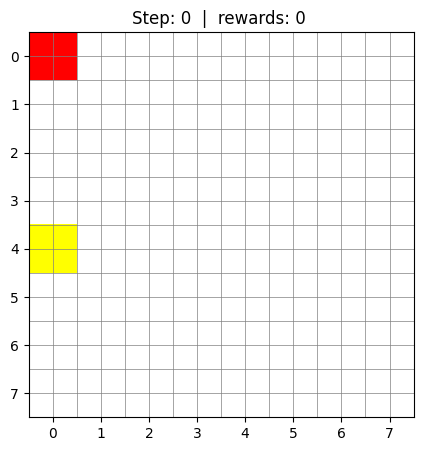

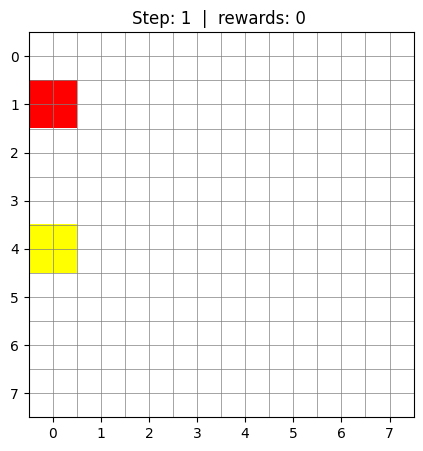

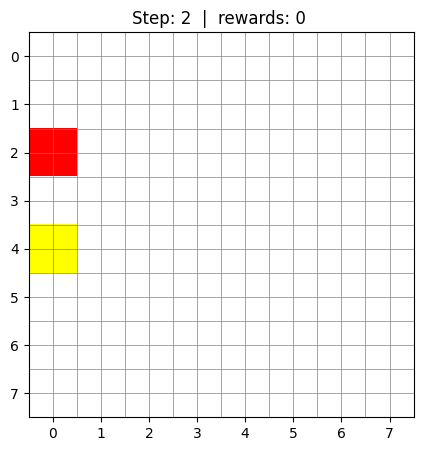

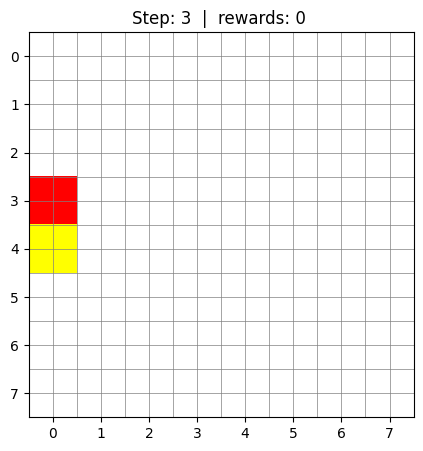

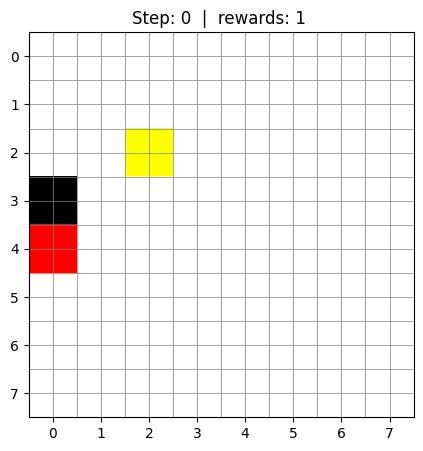

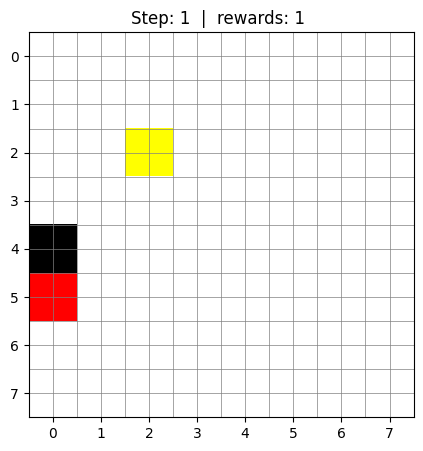

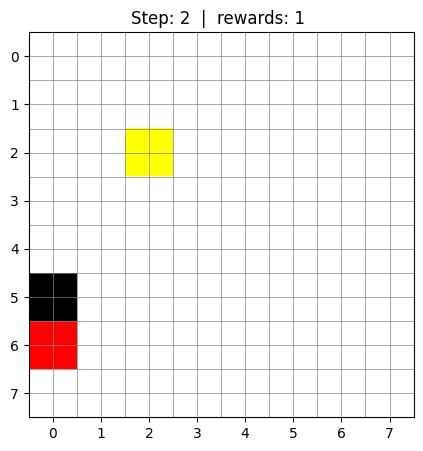

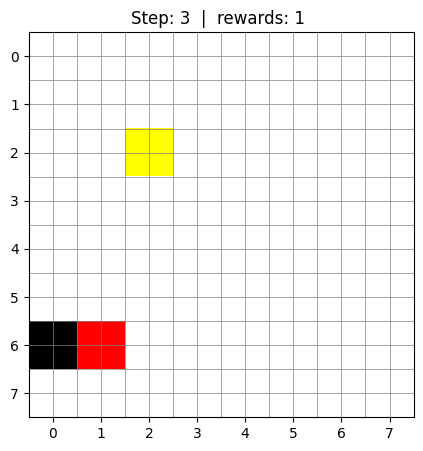

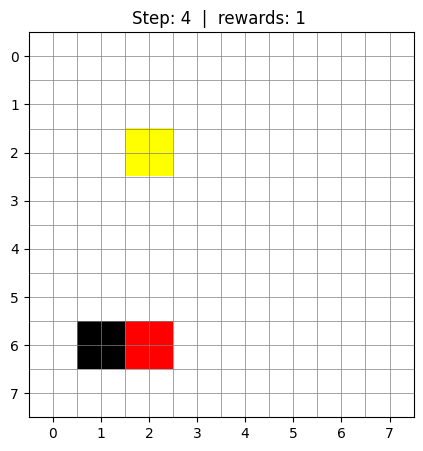

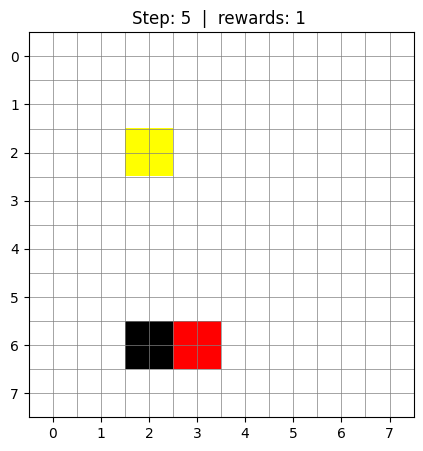

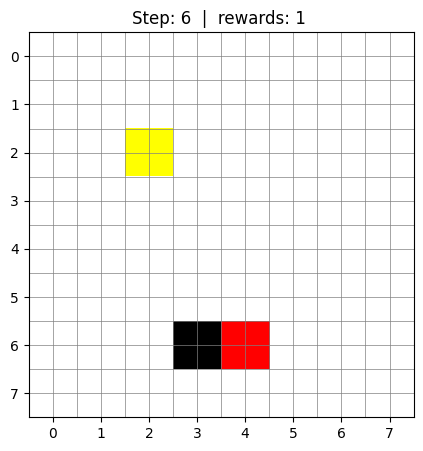

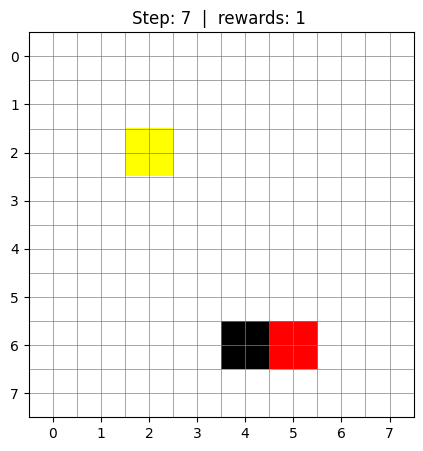

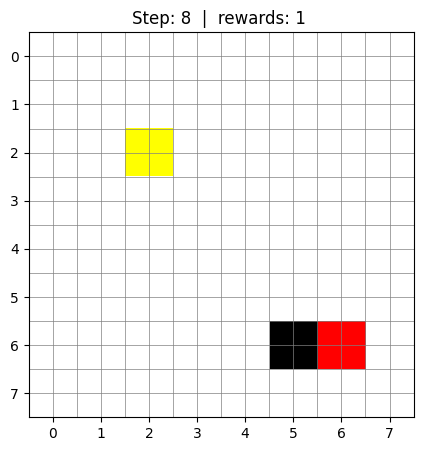

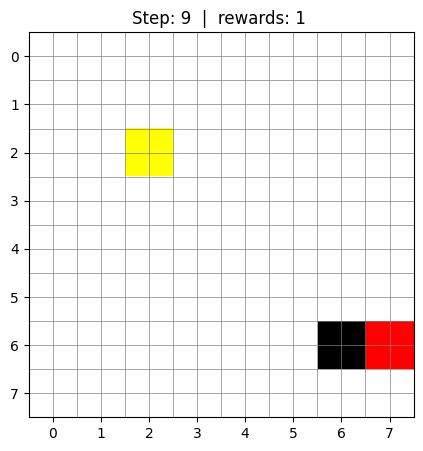

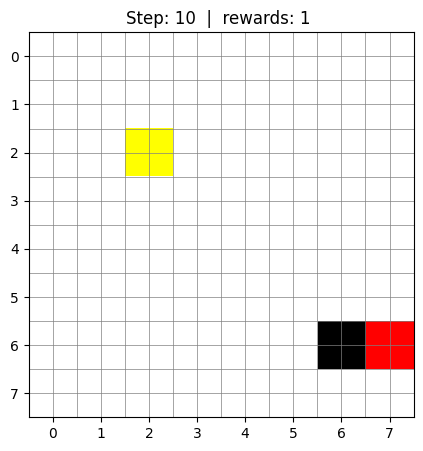

In [20]:
# Create an instance of the Snake environment
env = SnakeEnv(grid_size=grid_size, max_steps=n_max_steps)

obs = env.reset()
env.render()

done = False
while not done:
    # Flatten the observation and add batch dimension
    obs_tensor = tf.constant(obs.flatten(), dtype=tf.float32)[tf.newaxis]

    # Predict action probabilities
    action_probas = model(obs_tensor)

    # Choose the action with the highest probability
    action_index = tf.argmax(action_probas, axis=1).numpy()[0]

    # Map action index to action string
    action_map = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}
    action_string = action_map[action_index]

    # Take a step in the environment
    obs, reward, done, info = env.step(action_string)

    # Render the environment
    env.render()

### 儲存訓練好的模型 (包含優化器狀態)
您可以使用 `model.save()` 方法將訓練好的模型連同優化器狀態一起儲存到磁碟。Keras 預設會儲存這些資訊，以便後續可以從中斷處繼續訓練。

In [ ]:
# 定義模型儲存的路徑和名稱
model_save_path = "snake_policy_model"

# 儲存模型，會包含模型結構、權重和優化器狀態
model.save(model_save_path)

print(f"模型已儲存到：{model_save_path}")

### 載入儲存的模型並繼續訓練
要使用儲存的模型並從中斷處繼續訓練，您可以使用 `keras.models.load_model()` 函數載入模型。載入的模型會恢復原始模型的結構、權重和優化器狀態。然後您可以直接在載入的模型上呼叫訓練函數。

In [ ]:
# 定義模型載入的路徑和名稱
model_load_path = "snake_policy_model"

# 載入模型，會恢復模型、權重和優化器狀態
loaded_model = keras.models.load_model(model_load_path)

print(f"模型已從 {model_load_path} 載入成功！")

# 現在您可以在 loaded_model 上繼續訓練，例如：
# 定義需要繼續訓練的迭代次數
# continue_training_iterations = 500

# 確保使用與訓練時相同的環境、優化器和損失函數等設定 (如果需要)
# env = SnakeEnv(grid_size=grid_size, max_steps=n_max_steps)
# optimizer = keras.optimizers.Adam(learning_rate=0.01) # 通常載入的模型會包含優化器，這行可能不需要
# loss_fn = keras.losses.categorical_crossentropy # 這需要在訓練迴圈中設定

# 繼續執行訓練迴圈，只是從 loaded_model 開始
# for iteration in range(continue_training_iterations):
#     all_rewards, all_grads = play_multiple_episodes(
#         env, n_episodes_per_update, n_max_steps, loaded_model, loss_fn)
#     # ... 後續訓練邏輯 ...